In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastai.tabular import *
from fastai.text import *

In [3]:
PATH = Path()

In [4]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [5]:
loss_fn = CrossEntropyFlat()

def f1(preds, targs):
    # metrics must return a rank0 tensor
    return tensor(f1_score(targs.view(-1).detach().cpu(), preds.argmax(-1).view(-1).detach().cpu(), average='macro'))

In [6]:
# train = pd.read_csv(PATH/"train.csv")
# test = pd.read_csv(PATH/"test.csv")

train = pd.read_csv(PATH/"train_clean.csv")   # data-without-drift
test = pd.read_csv(PATH/"test_clean.csv")

# train = pd.read_csv(PATH/"train_detrend.csv") # detrended w/ histogram
# test = pd.read_csv(PATH/"test_detrend.csv")

In [7]:
def trn_val_split(rows, percent=0.2):   # randomized non-sequential splits
    "returns trn_idxs, val_idxs"
    indices = np.random.permutation(rows)  # randomly permute rows
    num = int(rows*percent)
    return indices[num:], indices[:num]

In [8]:
class Ion_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x,y

In [9]:
def show_subset(start,end,step,df=train,add_fields=[]):
    plt.figure(figsize=(20,5))
    plt.plot(df.signal[start:end:step], label='signal')
    plt.plot(df.open_channels[start:end:step], label='open_channels')
    [plt.plot(df[field][start:end:step], label=field) for field in add_fields]
    plt.xlabel('Time (*1e4)', size=16)
    plt.ylabel('Signal / Channels Open', size=16); 
    plt.title(f'{start} - {end}  ({end-start}/{step})',size=20)
    plt.legend()
    plt.show()

def random_subsets(n=10, length=500, step=10, add_fields=None):
    for k in range(n):
        start = np.random.randint(0, len(train)-length)
        end = start + length
        show_subset(start,end,step,add_fields)

# Data Visualization

IMPORTANT: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001

In [20]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [ ]:
len(train)

In [ ]:
# imbalanced dataset
c = Counter(train.open_channels); c

c.most_common()

for i,n in c.most_common():
    print(f"{i}: {round(n/5000000, 2)}")

In [ ]:
train.describe()

In [ ]:
# signal stats
print(f"mean: {train.signal.mean()}\nmin: {train.signal.min()}\nmax: {train.signal.max()}")

In [ ]:
# open channel stats
print(f"mean: {train.open_channels.mean()}\nmin: {train.open_channels.min()}\nmax: {train.open_channels.max()}")

In [20]:
res = 10000    # step

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[0::res])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - batches / {res}',size=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.open_channels[0::res])

plt.vlines(range(0,len(train),500000),-1,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Open Channels', size=16);
plt.title(f'Open Channels - batches / {res}',size=20)
plt.show()

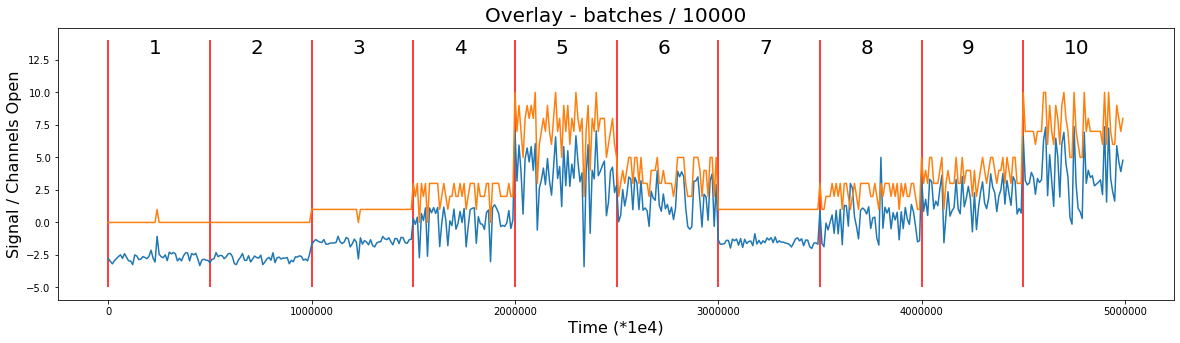

In [22]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[::res])

plt.plot(train.open_channels[::res])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal / Channels Open', size=16); 
plt.title(f'Overlay - batches / {res}',size=20)
plt.show()

## zoom in

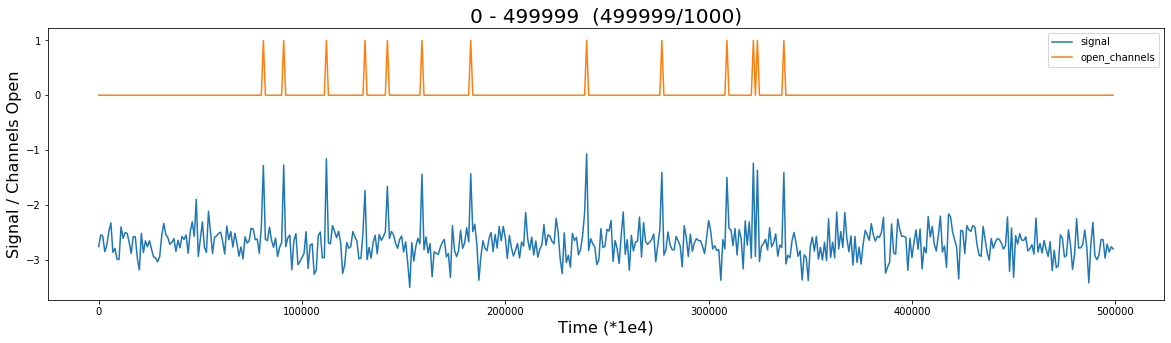

mean: -2.681, std: 0.33, Q01: -3.296, Q99: -1.365



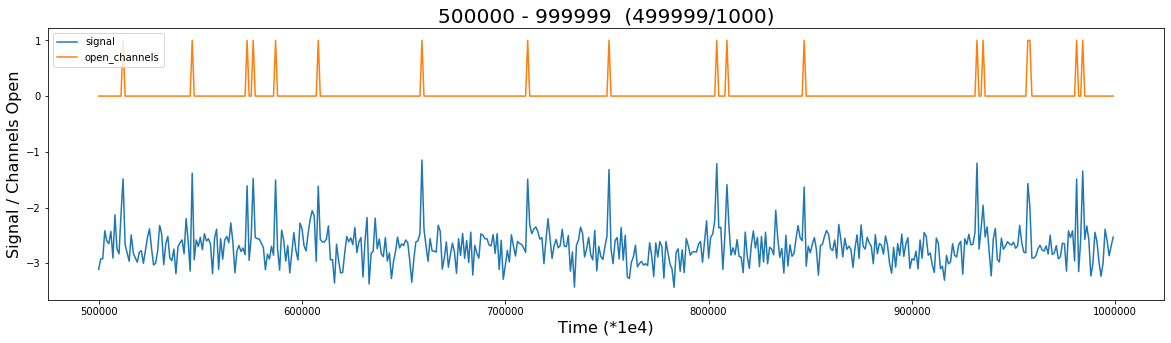

mean: -2.683, std: 0.346, Q01: -3.308, Q99: -1.328



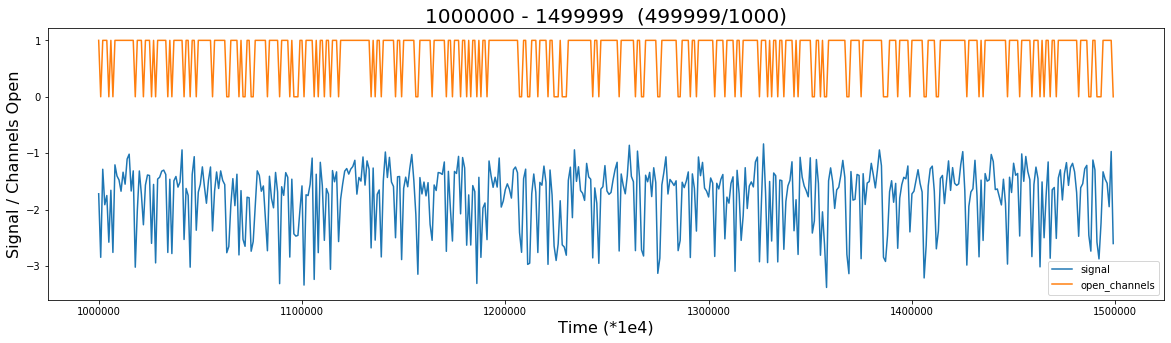

mean: -1.813, std: 0.59, Q01: -3.171, Q99: -0.953



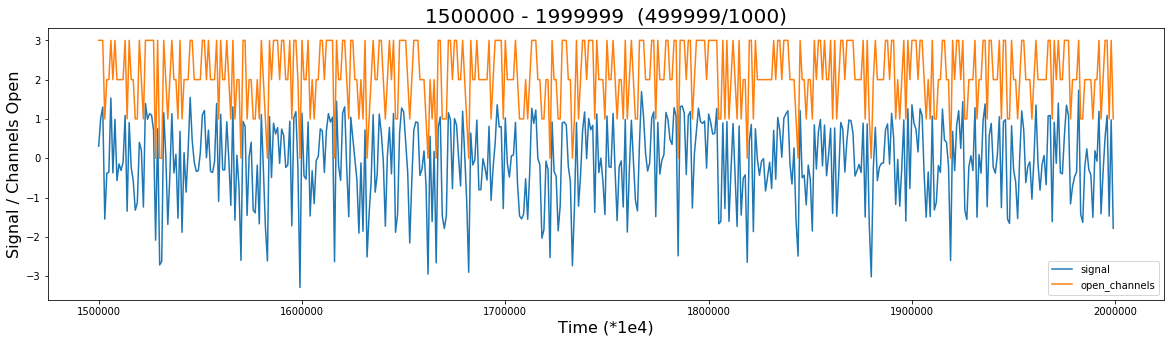

mean: -0.093, std: 1.003, Q01: -2.792, Q99: 1.478



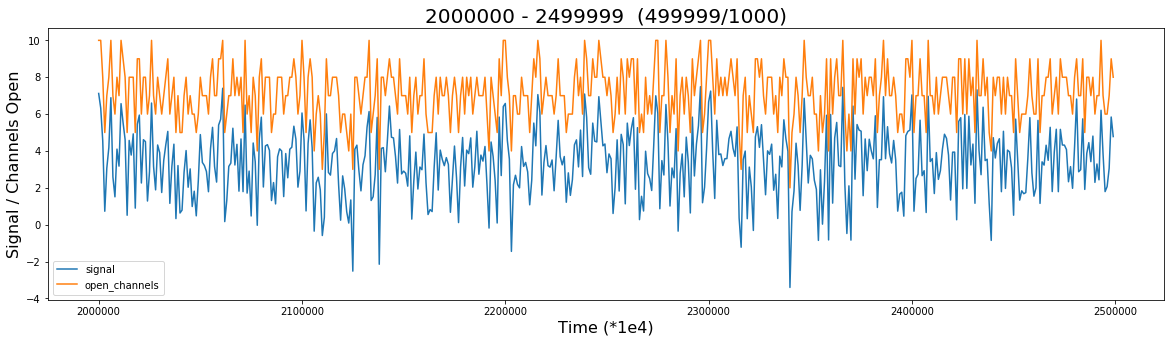

mean: 3.358, std: 1.818, Q01: -1.108, Q99: 7.125



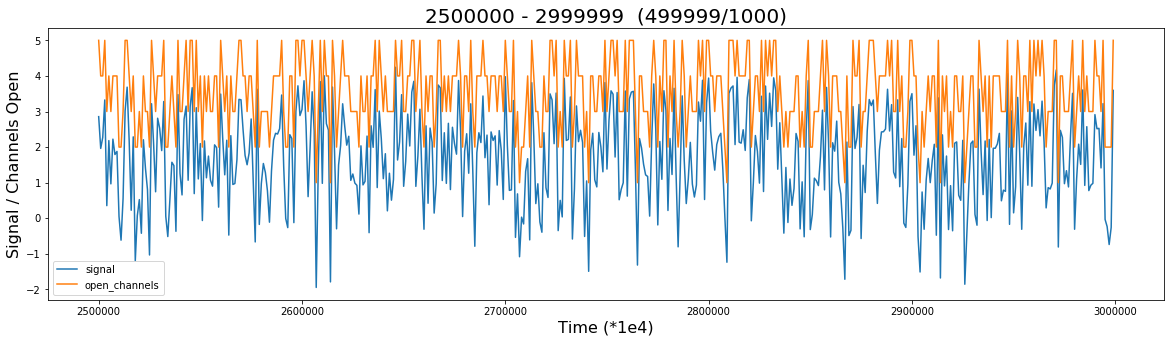

mean: 1.681, std: 1.279, Q01: -1.614, Q99: 3.906



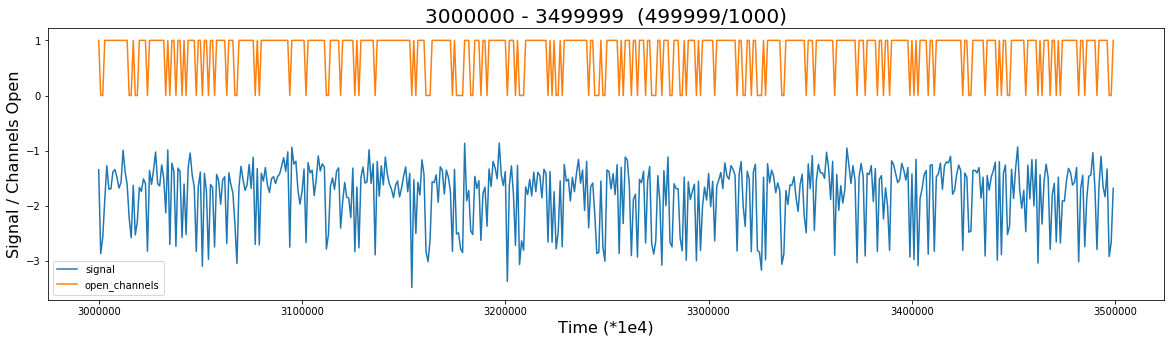

mean: -1.804, std: 0.586, Q01: -3.166, Q99: -0.952



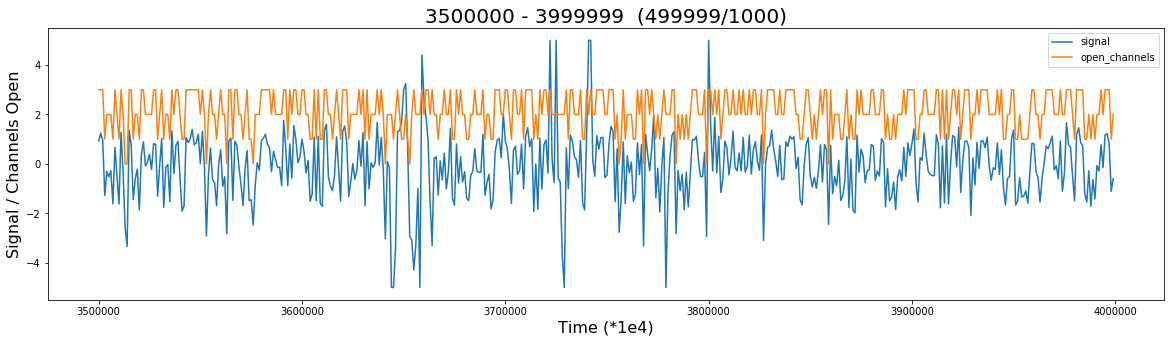

mean: -0.108, std: 1.17, Q01: -3.133, Q99: 1.9



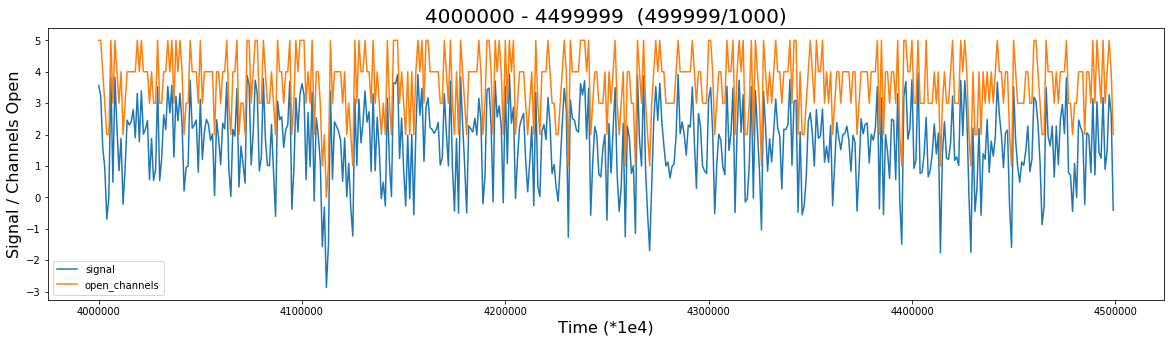

mean: 1.659, std: 1.284, Q01: -1.634, Q99: 3.894



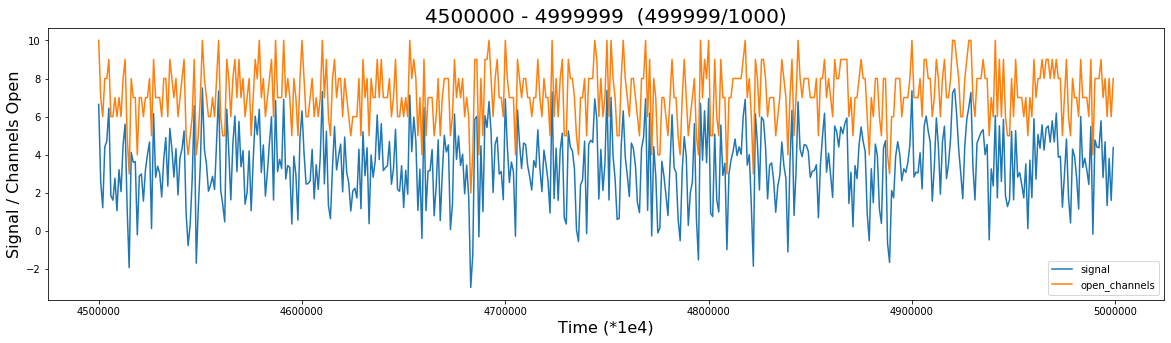

mean: 3.311, std: 1.819, Q01: -1.124, Q99: 7.113



In [36]:
for beg,end in zip(steps[0::1],steps[1::1]):
    show_subset(beg,end-1,1000)
    group = train[beg:end].signal
    print(f"mean: {round(group.mean(), 3)}, std: {round(group.std(), 3)}, \
Q01: {round(group.quantile(.01), 3)}, Q99: {round(group.quantile(.99),3)}\n")

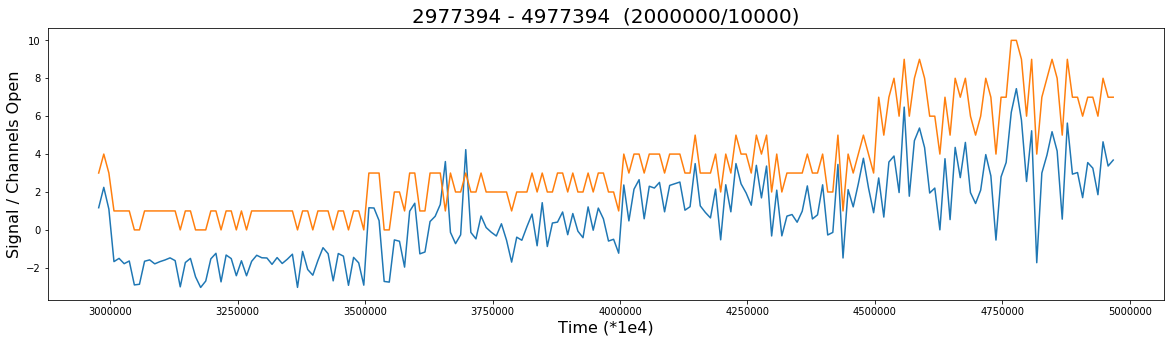

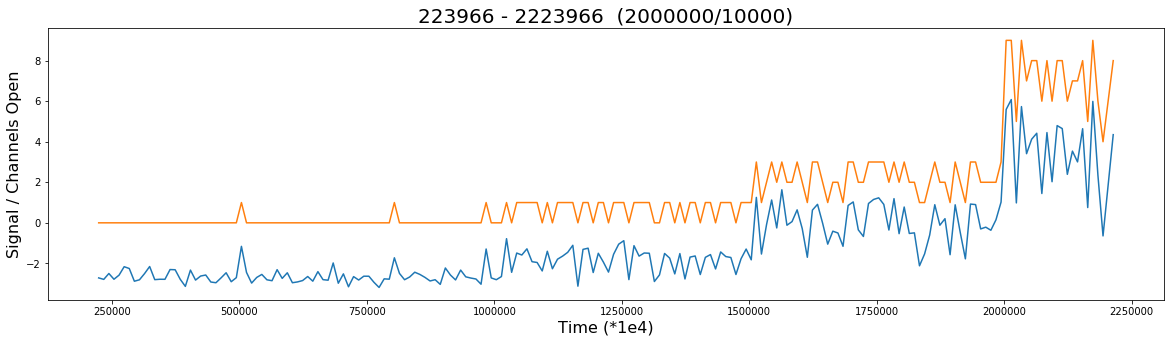

In [14]:
show_subsets(n=2, length=2000000, step=10000)

### Strange Behavior: open_channels < signal (~4000)

In [21]:
train[train.open_channels < train.signal]

,time,signal,open_channels
478587,47.8588,4.999800,0
478609,47.8610,3.537600,0
478610,47.8611,0.586400,0
599999,60.0000,0.297600,0
3642932,364.2933,4.999857,3
...,...,...,...
3822653,382.2654,4.445693,3
3822697,382.2698,4.999802,2
3822699,382.2700,2.708730,2
3822750,382.2751,3.152937,2


In [38]:
train[478580:478620]

,time,signal,open_channels,batch,sequence,seq_mean,bat_mean,ewma_1,ewma_5,ewma_10,ewma_100
478580,47.8581,-1.238618,0,0,119,-1.084504,-1.111037,-1.238618,-1.181809,-1.167250,-1.143437
478581,47.8582,-1.165983,0,0,119,-1.084504,-1.111037,-1.165983,-1.176534,-1.167019,-1.143883
478582,47.8583,-1.165099,0,0,119,-1.084504,-1.111037,-1.165099,-1.172722,-1.166670,-1.144303
478583,47.8584,-1.197417,0,0,119,-1.084504,-1.111037,-1.197417,-1.180954,-1.172260,-1.145355
478584,47.8585,-1.155210,0,0,119,-1.084504,-1.111037,-1.155210,-1.172373,-1.169160,-1.145550
478585,47.8586,-1.095599,0,0,119,-1.084504,-1.111037,-1.095599,-1.146781,-1.155786,-1.144561
478586,47.8587,-0.967091,0,0,119,-1.084504,-1.111037,-0.967091,-1.086885,-1.121477,-1.141047
478587,47.8588,1.976535,0,0,119,-1.084504,-1.111037,1.976535,-0.065745,-0.558202,-1.079313
478588,47.8589,-0.758190,0,0,119,-1.084504,-1.111037,-0.758190,-0.296560,-0.594564,-1.072954
478589,47.8590,-1.105648,0,0,119,-1.084504,-1.111037,-1.105648,-0.566256,-0.687488,-1.073601


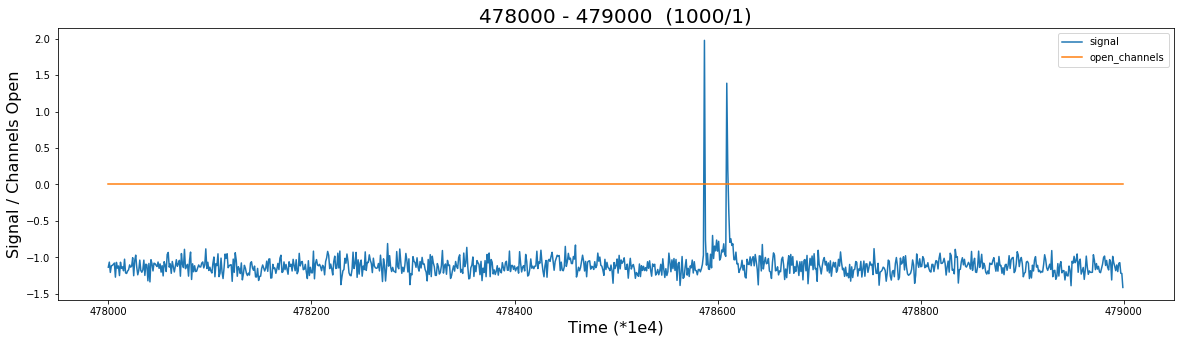

In [37]:
show_subset(478000,479000,1)

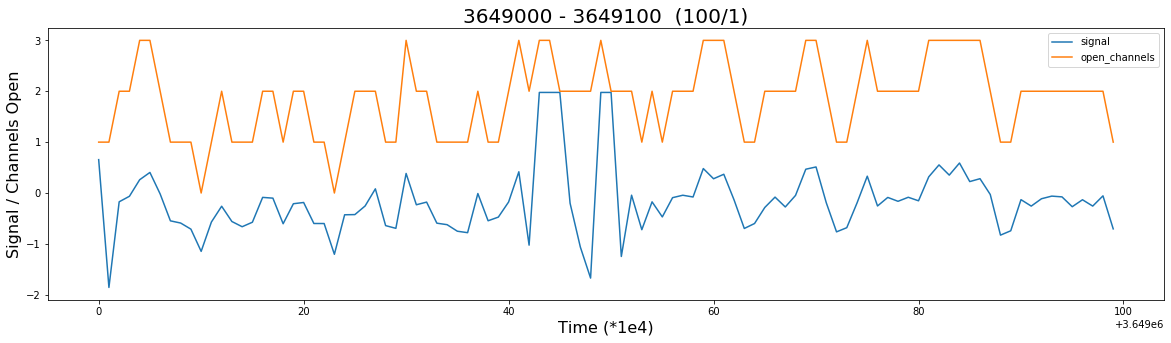

In [41]:
show_subset(3649000,3649100,1)

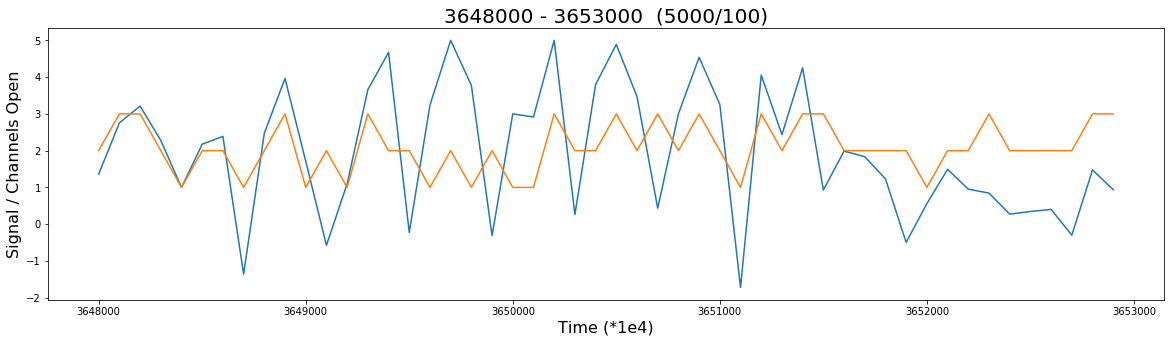

In [39]:
show_subset(3648000,3653000,100)

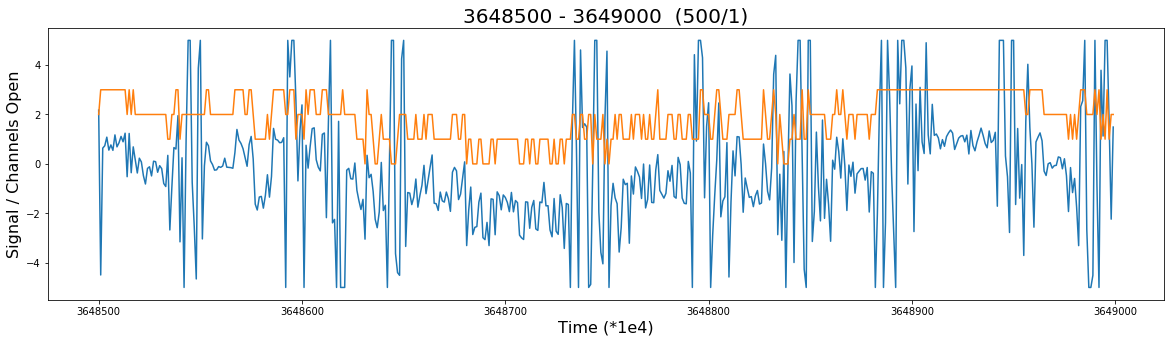

In [9]:
show_subset(3648500,3649000,1)

In [10]:
weird = train[3648500:3649000]

In [11]:
weird.describe()

,time,signal,open_channels
count,500.000000,500.000000,500.000000
mean,364.875050,-0.246584,1.864000
std,0.014448,2.343139,0.907276
min,364.850100,-5.000050,0.000000
25%,364.862575,-1.592084,1.000000
50%,364.875050,-0.279536,2.000000
75%,364.887525,0.939524,3.000000
max,364.900000,4.999896,3.000000


## Test

In [28]:
res = 5000

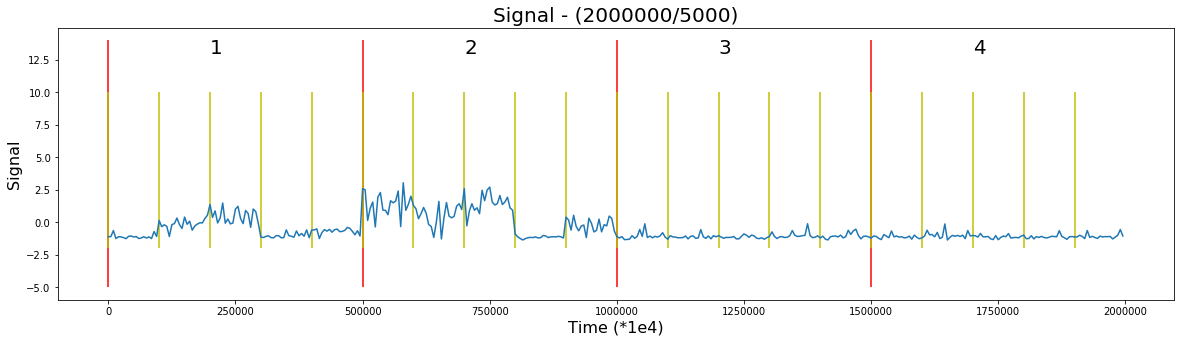

In [31]:
plt.figure(figsize=(20,5))
plt.plot(test.signal[0::res])

plt.vlines(range(0,len(test),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
plt.vlines(range(0,len(test),100000),-2,10,'y')
for j in range(4): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - ({len(test)}/{res})',size=20)
plt.show()

# Separate into 5 models

In [10]:
steps = list(range(0,5000001,500000))

for i,(beg,end) in enumerate(zip(steps[0::],steps[1::])):
    print(f"group {i+1}: {beg} - {end-1}")
    group = train[beg:end].signal
    print(f"mean: {round(group.mean(), 3)}, std: {round(group.std(), 3)}, \
Q01: {round(group.quantile(.01), 3)}, Q99: {round(group.quantile(.99),3)}\n")

In [ ]:
t_steps = list(range(0,2000001,100000))

for i,(beg,end) in enumerate(zip(t_steps[0::],t_steps[1::])):
    print(f"group {i+1} - {beg}:{end}")
    group = test[beg:end].signal
    print(f"mean: {round(group.mean(), 3)}, std: {round(group.std(), 3)}, \
Q01: {round(group.quantile(.01), 3)}, Q99: {round(group.quantile(.99),3)}\n")

In [10]:
df1 = train[0:1000000]
df2 = pd.concat([train[1000000:1500000],train[3000000:3500000]], ignore_index=True)
df3 = pd.concat([train[1500000:2000000],train[3500000:4000000]], ignore_index=True)
df4 = pd.concat([train[2000000:2500000],train[4500000:5000000]], ignore_index=True)
df5 = pd.concat([train[2500000:3000000],train[4000000:4500000]], ignore_index=True)

t1 = pd.concat([test[0:100000],test[300000:400000],test[800000:900000],test[1000000:]], ignore_index=True)
t2 = test[400000:500000]
t3 = pd.concat([test[100000:200000],test[900000:1000000]], ignore_index=True)
t4 = pd.concat([test[500000:600000],test[700000:800000]], ignore_index=True)
t5 = pd.concat([test[200000:300000],test[600000:700000]], ignore_index=True)

## Analyzing group4

In [14]:
# imbalanced dataset
c = Counter(df4.open_channels); c
#print(c.most_common())
for i,n in c.most_common():
    print(f"{i}: {round(n/len(df4), 4)} ({n})")

7: 0.265 (265015)
8: 0.2452 (245183)
6: 0.1881 (188112)
9: 0.1361 (136120)
5: 0.0917 (91701)
10: 0.0357 (35733)
4: 0.03 (29982)
3: 0.0069 (6939)
2: 0.0011 (1087)
1: 0.0001 (126)
0: 0.0 (2)


In [60]:
c3 = df4[df4.open_channels==3]
print(c3.signal.max(), c3.signal.min(), c3.signal.mean())

-0.3517 -3.4974720247055178 -1.7682698803556796


In [59]:
c2 = df4[df4.open_channels==2]
print(c2.signal.max(), c2.signal.min(), c2.signal.mean())

-1.459925362738529 -4.6254 -2.9689007948729866


In [57]:
c1 = df4[df4.open_channels==1]
print(c1.signal.max(), c1.signal.min(), c1.signal.mean())

-3.17677108462369 -5.3438 -4.193538093069338


In [58]:
c0 = df4[df4.open_channels==0]
print(c0.signal.max(), c0.signal.min(), c0.signal.mean())

-5.7481 -5.7965 -5.7722999999999995


In [25]:
df4.open_channels.clip(1).min()

1

In [103]:
t4[t4.signal<-5.5].time.values

array([556.7252])

In [104]:
subm[subm.time==556.7252]

,time,open_channels
567251,556.7252,1


In [105]:
subm.at[567251, 'open_channels'] = 0

### Graphs

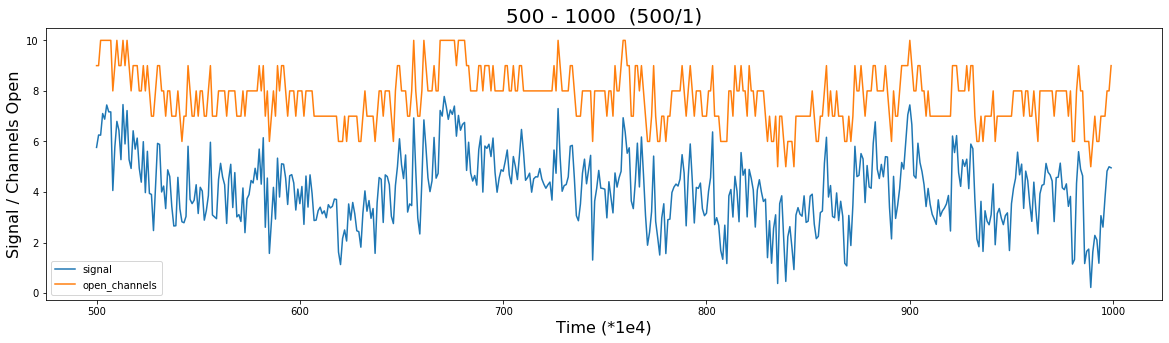

In [126]:
show_subset(500,1000,1,df4)

In [137]:
res = 1000

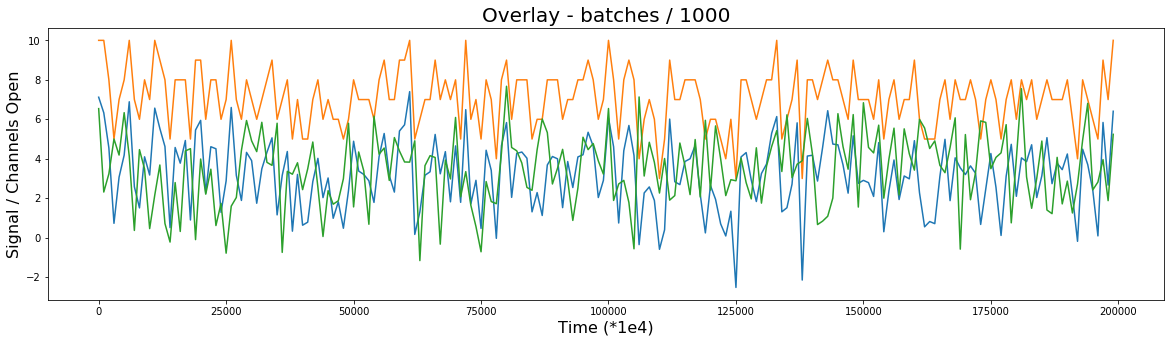

In [139]:
plt.figure(figsize=(20,5))
plt.plot(df4.signal[0:len(t4):res])
plt.plot(df4.open_channels[0:len(t4):res])
plt.plot(t4.signal[0::res])

# plt.vlines(range(0,len(df4),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
# for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal / Channels Open', size=16);
plt.title(f'Overlay - batches / {res}',size=20)
plt.show()

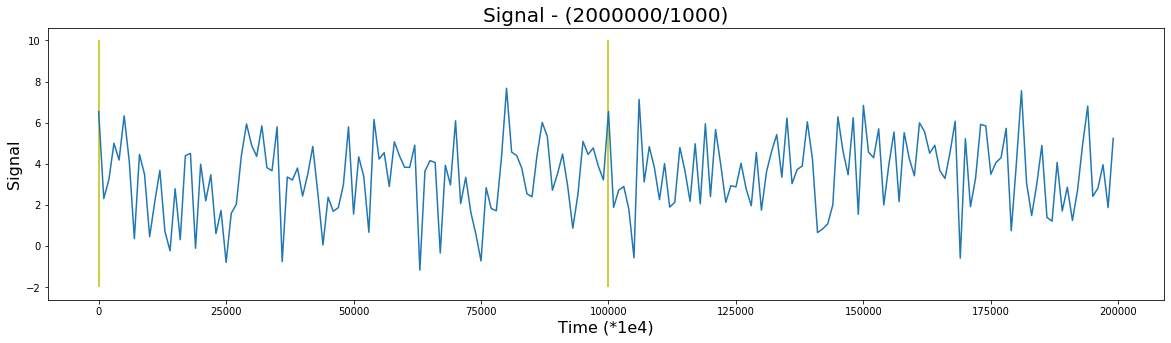

In [140]:
plt.figure(figsize=(20,5))
plt.plot(t4.signal[0::res])

#plt.vlines(range(0,len(t4),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
plt.vlines(range(0,len(t4),100000),-2,10,'y')
#for j in range(4): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - ({len(test)}/{res})',size=20)
plt.show()

### DecisionTrees and RandomForests

In [23]:
# import graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [24]:
def rf_feat_importance(m, feats):
    #return {f:i for f,i in zip(feats,m.feature_importances_)}
    return pd.DataFrame({'feats':feats, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [282]:
# this is not as accurate as using seq_len datasets
# X = df4.signal.values.reshape(-1,1)
# Y = df4.open_channels.values.reshape(-1,1)

In [29]:
seq_len = 1000
bs = 30

In [185]:
# Single Feature
feats=['signal']

i = 4
X = eval('df'+str(i))['signal'].values.reshape(-1, seq_len, 1)
Y = eval('df'+str(i))['open_channels'].values.reshape(-1, seq_len)

tst_x = eval('t'+str(i))['signal'].values.reshape(-1, seq_len, 1)
tst_y = np.zeros_like(tst_x.squeeze())

In [243]:
# DecisionTree
trn_idx,val_idx = trn_val_split(X.shape[0], 0.1)
trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]

trn_x,trn_y = trn_x.reshape(-1,1),trn_y.reshape(-1,1)
val_x,val_y = val_x.reshape(-1,1),val_y.reshape(-1,1)

m = tree.DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_x, trn_y)
print('Trained model 4 (10 channels)')
preds = m.predict(val_x)
print('F1 validation score: ', f1_score(val_y,preds,average='macro'))

Trained model 4 (10 channels)
F1 validation score:  0.8533077919371884


#### RandomForest

In [30]:
# Multi Feature

trn_df,tst_df = df4.copy(),t4.copy()

for df in [trn_df,tst_df]:
    grouping_(df, seq_len)
    shift_with_diff_(df, [1,2,3])
    ewma_(df, [2,3,4,5])
    square_signal_(df)
    exp_signal_(df)

cols = trn_df.columns.values
dels = np.array(['time', 'batch', 'sequence', 'open_channels'], dtype='object')
feats = list(np.setdiff1d(cols,dels))
print(feats)

['diff_1', 'diff_2', 'diff_3', 'ewma_2', 'ewma_3', 'ewma_4', 'ewma_5', 'sig_exp', 'signal', 'signal2']


In [123]:
# X = np.array(list(trn_df.groupby('sequence').apply(lambda x: x[feats].values)))
# Y = np.array(list(trn_df.groupby('sequence').apply(lambda x: x['open_channels'].values)))

X = trn_df[feats].values.reshape(-1,len(feats))
Y = trn_df.open_channels.values.reshape(-1,)
print(X.shape, Y.shape)

(1000000, 10) (1000000,)


In [124]:
Y = Y.clip(5)
Y.min()

5

In [125]:
# RandomForest
np.random.seed(42)

trn_idx,val_idx = trn_val_split(X.shape[0], 0.1)
trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(val_y.shape)

# trn_x,trn_y = trn_x.reshape(-1,len(feats)),trn_y.reshape(-1,)
# val_x,val_y = val_x.reshape(-1,len(feats)),val_y.reshape(-1,)

(100000,)


In [126]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=50, n_jobs=-1)
m.fit(trn_x, trn_y)
preds = m.predict(val_x)
print('F1 validation score =', round(f1_score(val_y,preds,average='macro'),4))

# 0.8523  ['signal']
# 0.8523  ['signal', 'signal2']
# 0.8523  ['sig_exp', 'signal']
# 0.8523  ['signal', 'sig_exp', 'signal2']
# 0.8536  ['signal', 'ewma_2', 'ewma_3', 'ewma_4', 'ewma_5']
# 0.8569  ['signal', 'sig_exp', 'signal2', 'ewma_2', 'ewma_3', 'ewma_4', 'ewma_5']
# 0.8571  ['sig_exp', 'signal', 'signal2', 'ewma_2', 'ewma_3', 'ewma_5', 'ewma_4', 'diff_1', 'diff_2', 'diff_3']
# 0.8571  w/ shift
# 0.8571  Y.clip(1)
# 0.8757  Y.clip(2)
# 0.8815  Y.clip(3)
# 0.8871  Y.clip(4)
# 0.8939  Y.clip(5)

# 0.8560  w/ rolling
# 0.8560  rolling instead of ewma
# 0.8562  w/ ewma 10 & 25
# 0.8563  w/ diff 4 & 5
# 0.8566  signal w/ ewmas & diffs

F1 validation score = 0.8939


In [22]:
rf_feat_importance(m,feats)

,feats,imp
7,signal,0.393817
3,ewma_2,0.212930
4,ewma_3,0.154345
5,ewma_4,0.099514
6,ewma_5,0.048739
0,diff_1,0.042173
1,diff_2,0.034280
2,diff_3,0.014202


#### Train and Predict Test

In [281]:
tst_x = tst_df[feats].values.reshape(-1,len(feats))

In [280]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=50, n_jobs=-1)
m.fit(X, Y)
preds = m.predict(tst_x)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [50]:
subm = pd.read_csv(PATH/"subm_v6.csv")

In [49]:
g4 = pd.read_csv(PATH/"g4.csv"); g4.head()

,0
0,10
1,10
2,10
3,10
4,10


In [48]:
g42 = g4.copy()

In [52]:
len(np.where(g4['0']!=g42['0'])[0])

2800

In [53]:
results = subm.open_channels.values

In [54]:
preds = g4['0'].values

In [55]:
results[500000:600000] = preds[0:100000]
results[700000:800000] = preds[100000:]

In [111]:
rg4 = np.concatenate((results[500000:600000],results[700000:800000]))

In [63]:
subm.open_channels = results

In [107]:
subm.to_csv(PATH/'subm_v8.csv', index=False, float_format='%.4f')

In [14]:
# imbalanced dataset
c = Counter(subm.open_channels); c
#print(c.most_common())
for i,n in c.most_common():
    print(f"{i}: {round(n/len(subm), 4)} ({n})")

7: 0.265 (265015)
8: 0.2452 (245183)
6: 0.1881 (188112)
9: 0.1361 (136120)
5: 0.0917 (91701)
10: 0.0357 (35733)
4: 0.03 (29982)
3: 0.0069 (6939)
2: 0.0011 (1087)
1: 0.0001 (126)
0: 0.0 (2)


In [113]:
# imbalanced dataset
c = Counter(rg4); c
#print(c.most_common())
for i,n in c.most_common():
    print(f"{i}: {round(n/len(rg4), 4)} ({n})")

7: 0.2659 (53187)
8: 0.2473 (49452)
6: 0.1847 (36935)
9: 0.134 (26809)
5: 0.0922 (18436)
10: 0.0353 (7061)
4: 0.0318 (6358)
3: 0.0088 (1755)
1: 0.0 (6)
0: 0.0 (1)


# Single Feature Data

In [54]:
seq_len = 5000
bs = 30

In [11]:
X = train['signal'].values.reshape(-1, seq_len, 1)
Y = train['open_channels'].values.reshape(-1, seq_len)

tst_x = test['signal'].values.reshape(-1, seq_len, 1)
tst_y = np.zeros_like(tst_x.squeeze())

In [12]:
# normalize before split
mean,sigma = X.mean(),X.std()

X = (X-mean)/sigma
tst_x = (tst_x-mean)/sigma

print(X.mean(), X.std())
print(tst_x.mean(), tst_x.std())

1.064108801074326e-17 0.9999999999999998
-0.5534694036483198 0.9004955799436505


In [13]:
# split trn/val
trn_idx,val_idx = trn_val_split(X.shape[0])

trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(trn_x.shape, val_x.shape)

(1000, 4000, 1) (250, 4000, 1)


In [18]:
kf = KFold(n_splits=5, shuffle=True)
# shuffle=False => sequential splits: [0..250],[250..500],[500..750],[750..1000],[1000..1250]
for i,(trn_idx,val_idx) in enumerate(kf.split(X, Y)):
    trn_x, val_x = X[trn_idx], X[val_idx]
    trn_y, val_y = Y[trn_idx], Y[val_idx]
    
    print(trn_x.shape, val_x.shape)

[   1    2    3    4 ... 1246 1247 1248 1249]
[   0    6    8   10 ... 1234 1235 1237 1241]
[   0    2    3    5 ... 1244 1245 1246 1247]
[   1    4   21   22 ... 1236 1240 1248 1249]
[   0    1    2    4 ... 1246 1247 1248 1249]
[   3    9   16   24 ... 1191 1208 1214 1242]
[   0    1    3    4 ... 1245 1247 1248 1249]
[   2    5   11   13 ... 1228 1238 1244 1246]
[   0    1    2    3 ... 1244 1246 1248 1249]
[   7   15   19   23 ... 1239 1243 1245 1247]


In [ ]:
# # normalize after split
# trn_mean = trn_x.mean()
# trn_sigma = trn_x.std()

# trn_x = (trn_x - trn_mean)/trn_sigma
# val_x = (val_x - trn_mean)/trn_sigma
# tst_x = (tst_x - trn_mean)/trn_sigma

# print(trn_x.mean(), trn_x.std())
# print(val_x.mean(), val_x.std())
# print(tst_x.mean(), tst_x.std())

### DataBunch

In [ ]:
trn_ds = Ion_Dataset(trn_x, trn_y)
val_ds = Ion_Dataset(val_x, val_y)
tst_ds = Ion_Dataset(tst_x, tst_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)
tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False)

data = DataBunch(trn_dl, val_dl, test_dl=tst_dl)

# Additional Features

In [9]:
seq_len = 5000
bs = 30

In [10]:
# normalize
train_mean = train.signal.mean()
train_sigma = train.signal.std()

train['signal'] = (train.signal - train_mean) / train_sigma
test['signal'] = (test.signal - train_mean) / train_sigma

In [27]:
# np.clip is hacky way to get the std to near 1

def grouping_(df, seq, batch=100000):
    # group by batch
    df['batch'] = df.groupby(df.index//batch, sort=False)['signal'].agg(['ngroup']).values
    df['batch'] = df['batch'].astype(np.uint16)

    # group by seq_len
    df['sequence'] = df.groupby(df.index//seq, sort=False)['signal'].agg(['ngroup']).values
    df['sequence'] = df['sequence'].astype(np.uint16)

    # group_mean and percent change from group_mean
#     df['seq_mean'] = df.groupby('sequence')['signal'].transform('mean')
    #df['pct_seq_mean'] = np.clip((df['signal']/df['seq_mean'])-1,-2,2) #
    
#     df['bat_mean'] = df.groupby('batch')['signal'].transform('mean')
    #df['pct_bat_mean'] = np.clip((df['signal']/df['bat_mean'])-1,-2,2) #

def ewma_(df, windows):
    for w in windows:
        df['ewma_' + str(w)] = df.groupby('batch')['signal'].transform(lambda x: x.ewm(span=w).mean()).values
#         df['rolling_'+str(w)] = df.groupby('batch')['signal'].transform(lambda x: x.rolling(w).mean()).fillna(df['signal']).values

def shift_with_diff_(df, windows):
    # markovian process -> shift by 1 should be enough... but there appears to be delay in data sometimes
    for w in windows:
        df['shift_' + str(w)] = df.groupby('batch')['signal'].shift(w).fillna(df['signal'])
        #df['pct_change_' + str(w)] = np.clip((df['signal']/df['shift_' + str(w)])-1,-4,4) #
        df['diff_' + str(w)] = df['signal']-df['shift_' + str(w)]
        
        df.drop('shift_'+str(w), axis=1, inplace=True)
    
def square_signal_(df):
    df['signal2'] = df['signal']**2
    
def exp_signal_(df):
    df['sig_exp'] = np.exp(df.signal).values

In [135]:
def feature_engineering_(df, seq_len:int, diff_windows:list, ewma_windows:list):
    grouping_(df, seq_len)
    #shift_with_diff_(df, diff_windows)
    ewma_(df, ewma_windows)
#     square_signal_(df)
    exp_signal_(df)

In [272]:
for df in [train,test]:
    feature_engineering_(df, seq_len, [1,2,3], [2,3,4,5])

In [280]:
# check for na values
train.isnull().sum(), test.isnull().sum()

(time             0
 signal           0
 open_channels    0
 batch            0
 shift_1          0
 diff_1           0
 rolling_1        0
 shift_3          0
 diff_3           0
 rolling_3        0
 shift_5          0
 diff_5           0
 rolling_5        0
 shift_10         0
 diff_10          0
 rolling_10       0
 ewma_5           0
 ewma_10          0
 ewma_100         0
 dtype: int64,
 time          0
 signal        0
 batch         0
 shift_1       0
 diff_1        0
 rolling_1     0
 shift_3       0
 diff_3        0
 rolling_3     0
 shift_5       0
 diff_5        0
 rolling_5     0
 shift_10      0
 diff_10       0
 rolling_10    0
 ewma_5        0
 ewma_10       0
 ewma_100      0
 dtype: int64)

In [17]:
cols = train.columns.values
dels = np.array(['time', 'batch', 'sequence', 'open_channels'], dtype='object')
feats = list(np.setdiff1d(cols,dels))
print(feats)

['diff_1', 'diff_10', 'diff_2', 'diff_3', 'diff_5', 'ewma_10', 'ewma_100', 'ewma_5', 'rolling_11', 'rolling_2', 'rolling_3', 'rolling_4', 'rolling_6', 'shift_1', 'shift_10', 'shift_2', 'shift_3', 'shift_5', 'signal']


In [15]:
random_subsets(n=5, length=50000, step=1000, add_fields=['ewma_10', 'ewma_100', 'ewma_1000'])

NameError: name 'random_subsets' is not defined

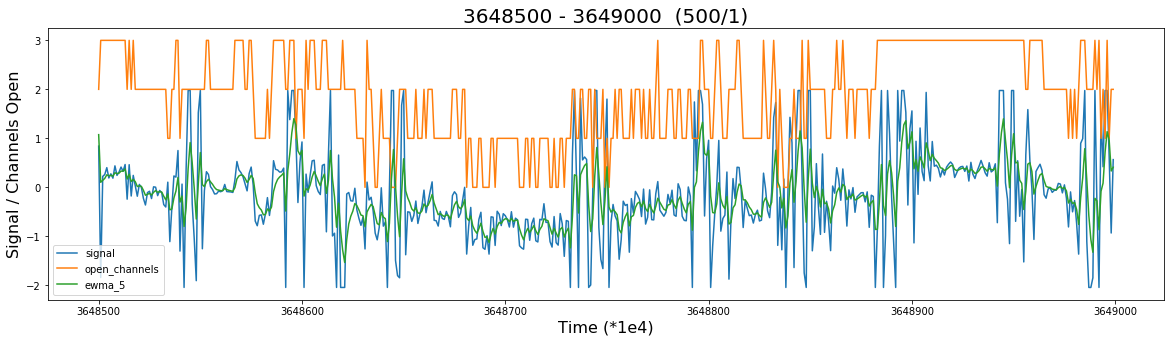

In [22]:
show_subset(3648500,3649000,1, add_fields=['ewma_5'])

In [12]:
X = np.array(list(train.groupby('sequence').apply(lambda x: x[feats].values)))
Y = np.array(list(train.groupby('sequence').apply(lambda x: x['open_channels'].values)))

TEST = np.array(list(test.groupby('sequence').apply(lambda x: x[feats].values)))

In [13]:
print(X.shape, Y.shape)
print(TEST.shape)

(1250, 4000, 23) (1250, 4000)
(500, 4000, 23)


### split trn/val

In [16]:
trn_idx,val_idx = trn_val_split(X.shape[0])

trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(trn_x.shape, val_x.shape)

(1000, 4000, 23) (250, 4000, 23)


In [ ]:
# normalize each feature individually after train/val split??

### Normalize

In [30]:
# set norms from trn_x
trn_means = trn_x.mean(axis=(0,1))
trn_stds = trn_x.std(axis=(0,1))

In [35]:
# normalize
trn_x = (trn_x - trn_means)/trn_stds
val_x = (val_x - trn_means)/trn_stds

In [37]:
val_x.std(axis=(0,1))

array([0.998668, 0.989504, 0.990879, 0.989911, 0.974792, 0.973682, 0.974845, 0.976355, 0.975879, 0.974602, 0.974201,
       0.975701, 0.965329, 0.996149, 0.994294, 0.989213, 0.989158, 0.989158, 0.989139, 0.989208, 0.989219, 0.989216,
       0.9379  ])

### DataBunch

In [85]:
trn_ds = Ion_Dataset(trn_x, trn_y)
val_ds = Ion_Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)

data = DataBunch(trn_dl, val_dl)

# WaveNet

In [40]:
#convlution formula: output = input + 2*padding - kernel_size - (kernel_size-1)*(dilation-1)

def padding(i, o, d, k=3, s=1):
    return ((o-1)*s + (k-1)*(d-1) + k - i)/2

# k=3: padding = dilation    => maintain size
# k=2: padding = dilation//2 => maintain size
# k=1: padding = 0           => maintain size

In [122]:
class Gated_Activation_Unit(Module):
    # w/ residual connection, batchnorm, and dropout
    def __init__(self, c, d, k=2, drop=0.2):
        self.d = d
        self.conv1 = nn.Conv1d(c, c, k, padding=self._pad(k,d), dilation=d) 
        self.tanh = nn.Tanh()
        self.conv2 = nn.Conv1d(c, c, k, padding=self._pad(k,d), dilation=d)
        self.sigm = nn.Sigmoid()
        self.conv_out = nn.Conv1d(c, c, 1)
        self.bn = nn.BatchNorm1d(c)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        res = x
        if self.d == 1: x = F.pad(x, (0,1))  # need asymmetric padding for dilation=1 scenario
        tanh = self.tanh(self.conv1(x))
        sigm = self.sigm(self.conv2(x))
        x = self.conv_out(tanh * sigm)
        x = self.bn(res + x)
        return self.drop(x)
       
    def _pad(self,k,d): return {3:d, 2:d//2, 1:0}[k]
    
    
class WaveBlock(Module):
    def __init__(self, in_c, out_c, dilations, drop):
        self.conv_in = nn.Conv1d(in_c, out_c, 1)
        self.layers = nn.Sequential(*[Gated_Activation_Unit(out_c,2**i,drop=drop) for i in range(dilations)])
    
    def forward(self, x): return self.layers(self.conv_in(x))
    
    
class CBR(Module):
    def __init__(self, in_c, out_c, k=3):
        self.layers = nn.Sequential(
            nn.Conv1d(in_c, out_c, k, padding=k//2),
            nn.BatchNorm1d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x): return self.layers(x)

In [123]:
class WaveNet(Module):
    # without the skip connections
    def __init__(self, in_dim=1, out_dim=11, drop=0.2, channels=[16,32,64,128], dilations=[12,8,4,1]):
        channels = [in_dim]+channels

        self.blocks = nn.Sequential(*[WaveBlock(*args,drop) for args in zip(channels[0::1], channels[1::1], dilations)])
        # zip channels/dilations yielding: (c0,c1,d0), (c1,c2,d1), (c2,c3,d2), etc.
        self.out = nn.Linear(channels[-1], out_dim)
        self.drop = nn.Dropout(drop)
#         self.cbr1 = CBR(in_dim,64)
#         self.cbr2 = CBR(128,32)

    def forward(self, x):
        x = x.permute(0,2,1)
        #x = self.cbr1(x)
        x = self.blocks(x)
        #x = self.cbr2(x)
        x = self.drop(x)
        
        x = x.permute(0,2,1)
        return self.out(x)

In [124]:
learn = Learner(data, WaveNet(len(feats),11), loss_func=loss_fn, metrics=[f1]) #, path=OUT_PATH)

In [126]:
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback

In [125]:
learn.fit(1,1e-2, callbacks=[SaveModelCallback(learn, name='best'),
                             ReduceLROnPlateauCallback(learn, patience=5, factor=0.5, min_lr=1e-5)])

epoch,train_loss,valid_loss,f1,time


KeyboardInterrupt: 

In [139]:
subm = pd.read_csv(PATH/'subm_v2.csv')

In [149]:
t = tensor(subm.open_channels.values); t.shape

torch.Size([2000000])

In [150]:
stack = torch.stack([t,t,t,t,t], dim=-1)

In [156]:
stack.mode(dim=-1)

torch.return_types.mode(
values=tensor([0, 0, 0,  ..., 0, 0, 0]),
indices=tensor([4, 4, 4,  ..., 4, 4, 4]))

In [146]:
len(np.where(subm.open_channels == subm1.open_channels)[0])

1986628

# Deep-Channel

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale dataset between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset.min(), dataset.max(), dataset.mean(), dataset.std()

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE - Synthetic Minority Over-sampling Technique -> resample all classes to equal the majority class
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_res, Y_res = sm.fit_sample(x_train, y_train)

In [ ]:
class DeepChannel(Module):
    def __init__(self, feats, in_c=64, hid_c=256, out_c=11, num_layers=2):
        self.conv = nn.Conv1d(feats, in_c, 1, bias=False)
        self.bn = nn.BatchNorm1d(in_c)
        
        self.lstm1 = nn.LSTM(in_c, hid_c, batch_first=True, dropout=0.1)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(hid_c)
        
        self.lstm2 = nn.LSTM(hid_c, hid_c, batch_first=True, dropout=0.1)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm1d(hid_c)

        self.lstm3 = nn.LSTM(hid_c, hid_c, batch_first=True, dropout=0.1)
        self.relu3 = nn.ReLU(inplace=True)
        self.bn3 = nn.BatchNorm1d(hid_c)

        self.lin = nn.Linear(hid_c, out_c)

    def forward(self, input):
        x = self.bn(F.relu(self.conv(input)))
        x,_ = self.bn1(F.relu(self.lstm1(x)))
        x,_ = self.bn2(F.relu(self.lstm2(x)))
        x,_ = self.bn3(F.relu(self.lstm3(x)))
        return self.lin(x)

In [87]:
learn = Learner(db, model, loss_func=loss, metrics=[f1])

# 2 layer Bi-LSTM

In [ ]:
class Bi_RNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=11, num_layers=2):
        super(Bi_RNN, self).__init__()

        self.linear_in = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear_out = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input):
        linear_input = self.linear_in(input)
        lstm_out, self.hidden = self.lstm(linear_input)
        return self.linear_out(lstm_out)

In [87]:
learn = Learner(db, Bi_RNN(), loss_func=loss, metrics=[f1])

In [ ]:
# learn.clip_grad()

### Fit

In [ ]:
learn.fit(5, lr=1e-2)

# Seq Databunch

In [ ]:
class SeqProcessor():
    def __init__(self, ds:Collection=None, seq_len=5000):  self.seq_len = seq_len
    def process(self, ds:Collection):  ds.items = ds.items.reshape(-1, seq_len, 1)

In [ ]:
class SeqBatchSampler(torch.utils.data.Sampler):
    "split data up into n batches of seq_len"
    def __init__(self,data_source,seq_len):
        assert len(data_source)%seq_len==0
        self.seq_len = seq_len
        self.data_source = data_source.reshape(-1, seq_len, 1)

    def __len__(self): return len(self.data_source)
    def __iter__(self): return iter(self.data_source)

In [ ]:
d = ItemList.from_df(train, PATH, cols=1, processor=SeqProcessor)

In [ ]:
d.items

In [ ]:
def custom_collate(data):
    x,y = [],[]
    for ll in data:
        x.append(ll.x.items)
        y.append(ll.y.items)
    return (torch.Tensor(x), torch.LongTensor(y))

In [ ]:
class SeqDataBunch(DataBunch):
    @classmethod      # cls => databunch Class
    def create(cls, train_ds, valid_ds, test_ds=None, path='.',bs:int=30, seq_len:int=5000, **kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = []
        for ds in datasets:
            samp = SeqBatchSampler(ds,seq_len=seq_len)
            dataloaders.append(DataLoader(ds, batch_size=bs, sampler=samp))
        return cls(*dataloaders, path=path, collate_fn=custom_collate)
    
    def normalize(self, mean=0., std=1.)->None:
        self.add_tfm(partial(self.norm_x, mean=mean, std=std))
        return self
    
    @staticmethod
    def norm_x(batch:Tuple[Tensor,Tensor], mean:float, std:float)->Tuple[Tensor,Tensor]:
        x,y = batch
        x = (x-mean)/std
        return x,y

In [ ]:
class SeqList(ItemList): 
    _processor = [SeqProcessor]
    #_bunch = SeqDataBunch

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)

In [ ]:
1000*.2

In [ ]:
np.arange(len(train)).reshape(-1,5000)

In [ ]:
np.random.randint(1000, size=200)

In [ ]:
idxs = np.arange(len(train)).reshape(-1,5000)[:,-int(0.2):].flatten()

In [ ]:
def valid_idxs(df,seq_len=5000,percent=0.2):
    full = np.arange(len(df)).reshape(-1,seq_len)
    rows = full.shape[0]
    num = int(rows*percent)
    idx = np.random.randint(rows, size=num)
    return full[idx].flatten()

In [ ]:
v_idxs = valid_idxs(train)

In [ ]:
v_idxs

In [ ]:
bs=100
bptt=100

v_idxs = valid_idxs(train, seq_len)

In [ ]:
data = (SeqList.from_df(train, PATH, cols=1)
        .split_by_idx(v_idxs)
        .label_from_df(cols=2, label_cls=SeqList)
        .databunch(bs=30)
       )

In [ ]:
d = data.databunch(bs=30)

In [ ]:
%debug

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

# Mixed Sequential DataBunch

In [ ]:
# class NormProcessor(PreProcessor):
#     def __init__(self, ds:Collection=None):
#         self.means = ds.items.mean()
#         self.stds = ds.items.std()

#     def process_one(self, item:Any): return self.norm(item)
#     def process(self, ds:Collection): ds.items = self.norm(ds.items)
    
#     def norm(self, x): return (x - self.means)/(self.stds + 1e-7)

In [ ]:
class SeqBatchSampler(torch.utils.data.Sampler):
    "Return batches of indexes ~> [bs,bptt]"
    def __init__(self,data_source,bs=10,bptt=5000):
        self.length = len(data_source)
        assert self.length%bs==0
        self.bs,self.bptt = bs,bptt
        self.idxs = np.arange(self.length).reshape((bs,-1))

    def __len__(self): return self.length//self.bs
    
    def __iter__(self):
        self.cur_idx = 0
        return self
        
    def __next__(self):
        cur = self.cur_idx
        end = cur+self.bptt
        self.cur_idx = end
        res = self.idxs[:,cur:end]
        if res.shape[1] == 0: raise StopIteration
        return res

In [ ]:
def custom_collate(data):
    x,y = [],[]
    for ll in data:
        x.append(ll.x.items)
        y.append(ll.y.items)
    return (torch.Tensor(x), torch.LongTensor(y))

In [ ]:
class SeqDataBunch(DataBunch):
    @classmethod      # cls => databunch Class
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs:int=10, bptt:int=5000, **kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = []
        for ds in datasets:
            samp = SeqBatchSampler(ds,bs=bs,bptt=bptt)
            dataloaders.append(DataLoader(ds, batch_sampler=samp))
        return cls(*dataloaders, path=path, collate_fn=custom_collate)
    
    def normalize(self, mean=0., std=1.)->None:
        self.add_tfm(partial(self.norm_x, mean=mean, std=std))
        return self
    
    @staticmethod
    def norm_x(batch:Tuple[Tensor,Tensor], mean:float, std:float)->Tuple[Tensor,Tensor]:
        x,y = batch
        x = (x-mean)/std
        return x,y

In [ ]:
class SeqList(ItemList): 
    #_processor = [NormProcessor]
    _bunch = SeqDataBunch

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)

In [ ]:
def valid_idxs(df,bs=10,percent=0.2):
    length = len(df)
    pct = length/bs*percent
    assert pct.is_integer()
    return np.arange(length).reshape(bs,-1)[:,-int(pct):].flatten()

In [ ]:
bs=100
bptt=100

v_idxs = valid_idxs(train, bs=bs)

In [ ]:
data = (SeqList.from_df(train, PATH, cols=1)
        .split_by_idx(v_idxs)
        .label_from_df(cols=2)
        .databunch(bs=bs, bptt=bptt)
       )

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

## Visualize (unnormalized) training batch

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

## Visualize (normalized) training batch

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

# CNN + AWD_LSTM

In [ ]:
class ConvToLSTM(Module):
    def __init__(self, in_sz):
        self.conv = nn.Conv1d(1,in_sz,3,padding=1)
        
    def forward(self, input:Tensor):
        return self.conv(input.unsqueeze(1)).permute(0,2,1)

class mod_AWD_LSTM(Module):
    def __init__(self, in_sz:int, hid_sz:int, n_layers:int, hidden_p:float=0.2,
                 input_p:float=0.6, weight_p:float=0.5, bidir:bool=False):
        self.bs,self.in_sz,self.hid_sz,self.n_layers = 1,in_sz,hid_sz,n_layers
        self.n_dir = 2 if bidir else 1

        self.rnns = [nn.LSTM(self.in_sz if l == 0 else self.hid_sz, self.hid_sz//self.n_dir, 1,
                             batch_first=True, bidirectional=bidir) for l in range(n_layers)]
        self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:Tensor)->Tuple[Tensor,Tensor]:
        bs,sl,emb = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input)
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers-1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        self.hidden = to_detach(new_hidden, cpu=False)
        return raw_outputs, outputs

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = self.hid_sz // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

def get_model(in_sz=32, hid_sz=64, out_sz=11, n_layers=3, out_p=0.4, **kwargs):
    return SequentialRNN(
        ConvToLSTM(in_sz),
        mod_AWD_LSTM(in_sz,hid_sz,n_layers,**kwargs),
        LinearDecoder(out_sz, hid_sz, output_p=out_p)
    )

In [ ]:
model = get_model()

In [ ]:
from sklearn.metrics import f1_score

def f1(preds, targs):
    return tensor(f1_score(targs.view(-1).detach().cpu(), preds.argmax(-1).view(-1).detach().cpu(), average='macro'))

In [ ]:
learn = LanguageLearner(data, model, metrics=[f1])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn.model.reset()

In [ ]:
learn.fit_one_cycle(1, 1e-1)

# Tabular Model

In [ ]:
from fastai.tabular import *

In [ ]:
tab_data = TabularDataBunch.from_df(PATH, train[['signal','open_channels']], 'open_channels',
                                    valid_idx=range(4000000, 5000000))#, procs=[Normalize])

In [ ]:
learn = tabular_learner(tab_data, layers=[32,64], metrics=[accuracy, f1])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('tab_model')

# F1 evaluation

*positive class*: minority class(es)  
*negative class*: majority class

- Precision: number of true positive class predictions.  (minority class accuracy)
- Recall: number of positive class predictions made out of all positive examples in the dataset. (minority class coverage)
- F-Measure provides a single score that balances both the concerns of precision and recall in one number.

*precision* - TruePositives / (TruePositives + FalsePositives)  
*recall* - TruePositives / (TruePositives + FalseNegatives)

| *Binary*        | Positive Prediction | Negative Prediction |
| :-------------: | ------------------- | ------------------- |
|**Positive Class** | True Positive (TP) | False Negative (FN) |
|**Negative Class** | False Positive (FP) | True Negative (TN) |

In [ ]:
TP = (preds * y).sum(); TP

In [ ]:
prec = TP / preds.sum(); prec

In [ ]:
rec = TP / y.sum(); rec

In [ ]:
f1 = (prec*rec)/(prec+rec+1e-9)*2; f1

In [ ]:
TP = (y_pred*y_true).sum()
prec = TP/(y_pred.sum(dim=1)+eps)
rec = TP/(y_true.sum(dim=1)+eps)
res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)

In [ ]:
def evaluate(model,x,y):
    model.eval()
    with torch.no_grad():
        res = model(x)
        preds = res.argmax(dim=-1)
        f1
learn.model()